In [1]:
import os 
import pandas as pd 
from sklearn.model_selection import train_test_split

Load the Data


In [2]:
benign ='data/archive/Dataset_BUSI_with_GT/benign'
malignant='data/archive/Dataset_BUSI_with_GT/malignant'
normal='data/archive/Dataset_BUSI_with_GT/normal'

In [3]:
count_benign=len(os.listdir(benign))
count_malignant=len(os.listdir(malignant))
count_normal=len(os.listdir(normal))

print((count_benign))
print(count_malignant)
print(count_normal)

891
421
266


Look at the data

In [4]:
def create_data(data_dir, categories):
    images = []
    masks = []
    labels = []

    for i, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        for file_name in os.listdir(category_dir):
            if "_mask" in file_name:
                continue
            image_file_path = os.path.join(category_dir, file_name)
            mask_file_name = file_name.replace(".", "_mask.")
            mask_file_path = os.path.join(category_dir, mask_file_name)
            if not os.path.exists(mask_file_path):
                continue
            images.append(image_file_path)
            masks.append(mask_file_path)
            labels.append(category)

    print(f"Found {len(images)} image/mask pairs in {len(categories)} categories")
    return images, masks, labels

In [5]:
data_dir ="data/archive/Dataset_BUSI_with_GT"

categories = ['benign','malignant','normal']

images,masks,labels=create_data(data_dir,categories)

id = [i for i in range(len(images))]

normal_labels = []
benign_labels = []
malignant_labels = []

for label in labels:
    normal_labels.append(float(1) if label=="normal" else float(0))
    benign_labels.append(float(1) if label=="benign" else float(0))
    malignant_labels.append(float(1)if label=="malignant" else float(0))



Found 780 image/mask pairs in 3 categories


In [6]:
import pandas as pd

images_df = pd.DataFrame({ "image":images})
#images_df.set_index('id')

labels_df = pd.DataFrame({ "normal": normal_labels, "benign":benign_labels, "malignant": malignant_labels},)
#labels_df.set_index('id')


In [7]:
from sklearn.model_selection import train_test_split


y = labels_df.sample(frac=1)
display(y)
x = images_df.loc[y.index].image.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

,normal,benign,malignant
324,0.0,1.0,0.0
533,0.0,0.0,1.0
628,0.0,0.0,1.0
292,0.0,1.0,0.0
269,0.0,1.0,0.0
...,...,...,...
648,1.0,0.0,0.0
92,0.0,1.0,0.0
98,0.0,1.0,0.0
438,0.0,0.0,1.0


In [8]:
x_train

,image
26,data/archive/Dataset_BUSI_with_GT\benign\benig...
341,data/archive/Dataset_BUSI_with_GT\benign\benig...
280,data/archive/Dataset_BUSI_with_GT\benign\benig...
649,data/archive/Dataset_BUSI_with_GT\normal\norma...
320,data/archive/Dataset_BUSI_with_GT\benign\benig...
...,...
300,data/archive/Dataset_BUSI_with_GT\benign\benig...
157,data/archive/Dataset_BUSI_with_GT\benign\benig...
228,data/archive/Dataset_BUSI_with_GT\benign\benig...
34,data/archive/Dataset_BUSI_with_GT\benign\benig...


In [35]:
y_eval

,normal,benign,malignant
131,0.0,1.0,0.0
294,0.0,1.0,0.0
261,0.0,1.0,0.0
247,0.0,1.0,0.0
331,0.0,1.0,0.0
...,...,...,...
121,0.0,1.0,0.0
444,0.0,0.0,1.0
616,0.0,0.0,1.0
373,0.0,1.0,0.0


In [10]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
benign,56,55
malignant,26,27
normal,17,16


In [11]:
import torch
# Use CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random

def plot_data(X,Y,label):
  
  index = Y[(Y[label] == 1)].sample(1).index[0]
  row = X.loc[index]
  
  img = cv2.imread(row['image'])

  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  axs[0].imshow(img)
  axs[0].set_title('Image')
  axs[1].text(0.5, 0.5, f'ID: {index}\nLabel: {label}', ha='center', va='center', fontsize=16)
  axs[1].axis('off')
  plt.show()

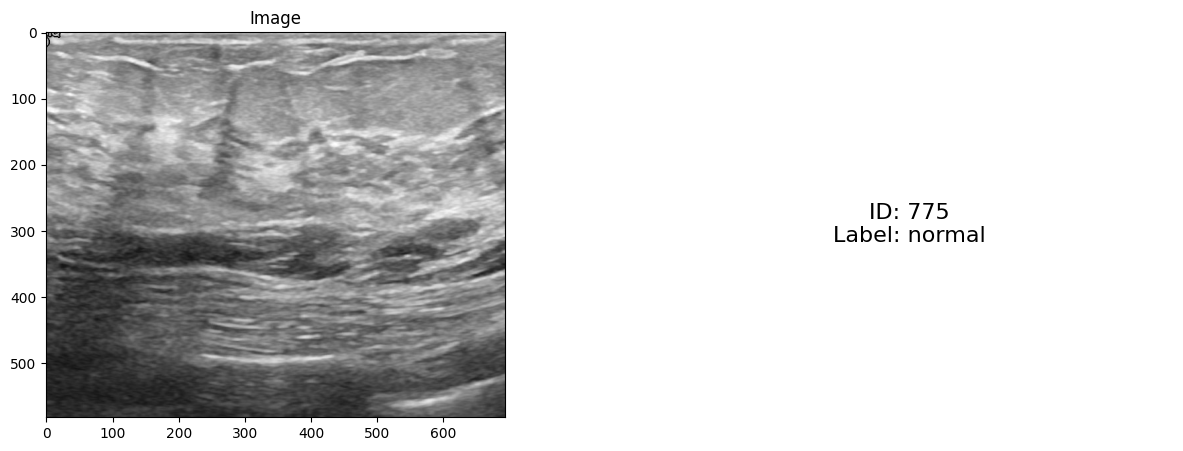

In [13]:
plot_data(x_train,y_train,"normal")

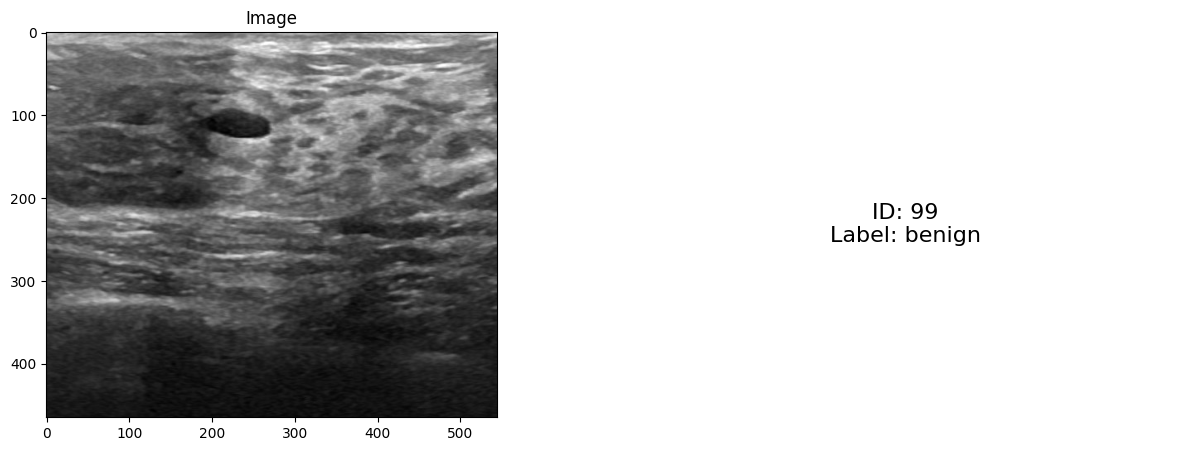

In [14]:
plot_data(x_train,y_train,"benign")

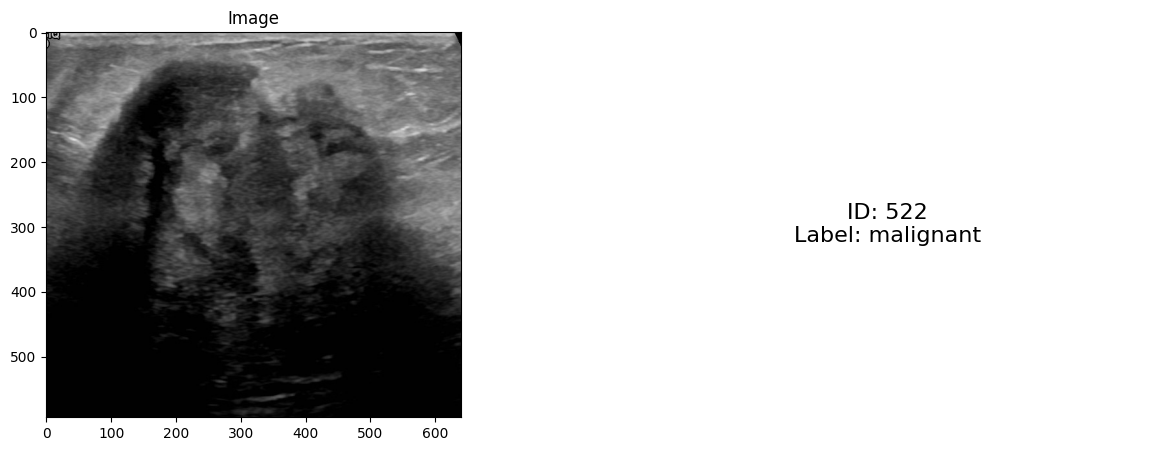

In [15]:
plot_data(x_train,y_train,"malignant")

In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["image"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image": image}
        else:
            label = torch.tensor(self.label.iloc[index], 
                                 dtype=torch.float)
            sample = {"image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [17]:
from torch import nn
import torchvision.models as models

model = models.resnet152(pretrained = True)

model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 3
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
# Send model to GPU
# Send the model to GPU
model = model.to(DEVICE)

In [22]:
from torch.utils.data import DataLoader
from tqdm import tqdm

num_epochs = 10

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")
    
    train_dataset = ImagesDataset(x_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=8)

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        
        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the forward step on this batch of images
        outputs = model(batch["image"].to(DEVICE))

        # 3) compute the loss
        loss = criterion(outputs, batch["label"].to(DEVICE))

        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

    print(f"The loss: {round(float(loss),2)} (Not averaged)")

Starting epoch 1


100%|██████████| 74/74 [00:17<00:00,  4.33it/s]


The loss: 0.42 (Not averaged)
Starting epoch 2


100%|██████████| 74/74 [00:17<00:00,  4.31it/s]


The loss: 0.24 (Not averaged)
Starting epoch 3


100%|██████████| 74/74 [00:16<00:00,  4.42it/s]


The loss: 0.07 (Not averaged)
Starting epoch 4


100%|██████████| 74/74 [00:16<00:00,  4.46it/s]


The loss: 0.02 (Not averaged)
Starting epoch 5


100%|██████████| 74/74 [00:16<00:00,  4.47it/s]


The loss: 0.04 (Not averaged)
Starting epoch 6


100%|██████████| 74/74 [00:16<00:00,  4.44it/s]


The loss: 0.12 (Not averaged)
Starting epoch 7


100%|██████████| 74/74 [00:16<00:00,  4.40it/s]


The loss: 0.0 (Not averaged)
Starting epoch 8


100%|██████████| 74/74 [00:17<00:00,  4.33it/s]


The loss: 0.01 (Not averaged)
Starting epoch 9


100%|██████████| 74/74 [00:16<00:00,  4.47it/s]


The loss: 0.0 (Not averaged)
Starting epoch 10


100%|██████████| 74/74 [00:16<00:00,  4.52it/s]

The loss: 0.01 (Not averaged)


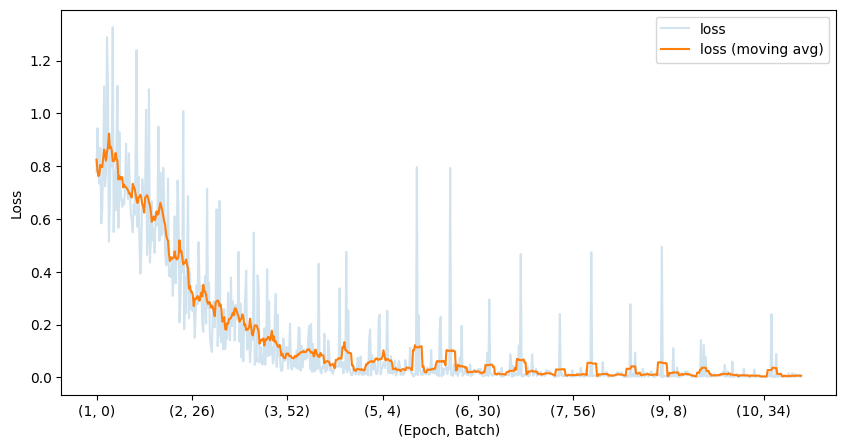

In [24]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

In [23]:
torch.save(model, "model.pth")

In [26]:
loaded_model = torch.load("model.pth")

In [49]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=1)

In [50]:
eval_dataloader.__len__()

195

In [52]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"].to(DEVICE))
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1).to(DEVICE)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.cpu().detach().numpy(),
            index = batch["image"],
            columns=categories,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

  0%|          | 0/195 [00:00<?, ?it/s]


TypeError: Index(...) must be called with a collection of some kind, tensor([[[[ 1.0331,  1.1358,  1.2728,  ...,  1.1015,  0.7419, -0.0458],
          [ 0.6734,  0.9817,  1.1015,  ...,  0.6392,  0.1939, -0.0972],
          [-0.2856, -0.0801, -0.0972,  ...,  0.2967,  0.2967,  0.2967],
          ...,
          [-1.0219, -0.8678, -0.6794,  ..., -1.4672, -1.3473, -1.2445],
          [-0.9192, -0.8335, -0.7137,  ..., -1.3644, -1.1760, -1.0733],
          [-0.9534, -0.9534, -0.9877,  ..., -1.1247, -0.9192, -0.8507]],

         [[ 1.1856,  1.2906,  1.4307,  ...,  1.2556,  0.8880,  0.0826],
          [ 0.8179,  1.1331,  1.2556,  ...,  0.7829,  0.3277,  0.0301],
          [-0.1625,  0.0476,  0.0301,  ...,  0.4328,  0.4328,  0.4328],
          ...,
          [-0.9153, -0.7577, -0.5651,  ..., -1.3704, -1.2479, -1.1429],
          [-0.8102, -0.7227, -0.6001,  ..., -1.2654, -1.0728, -0.9678],
          [-0.8452, -0.8452, -0.8803,  ..., -1.0203, -0.8102, -0.7402]],

         [[ 1.4025,  1.5071,  1.6465,  ...,  1.4722,  1.1062,  0.3045],
          [ 1.0365,  1.3502,  1.4722,  ...,  1.0017,  0.5485,  0.2522],
          [ 0.0605,  0.2696,  0.2522,  ...,  0.6531,  0.6531,  0.6531],
          ...,
          [-0.6890, -0.5321, -0.3404,  ..., -1.1421, -1.0201, -0.9156],
          [-0.5844, -0.4973, -0.3753,  ..., -1.0376, -0.8458, -0.7413],
          [-0.6193, -0.6193, -0.6541,  ..., -0.7936, -0.5844, -0.5147]]]]) was passed

In [80]:
a= model(eval_dataset.__getitem__(100)['image'].to(DEVICE).unsqueeze(0))

In [85]:
a.argmax()

tensor(2, device='cuda:0')

In [84]:
eval_dataset.__getitem__(100)['label'].argmax()

tensor(1)

In [ ]:
for each thing in test set

make set of answers/predictions
copare witb kaves 
